In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
from tqdm.auto import tqdm, trange
import xgboost as xgb
import joblib
from sklearn.model_selection import cross_validate
import zipfile

from src.model import tscv, ClippedOutputRegressor
from src.data import get_feature_cols, df_to_X_y, drop_non_features, add_lagged_features, add_as_features, df_to_X


%run constants.py

baseline_reg = joblib.load(os.path.join(MODELS_DIR, 'xgb-baseline.model'))

%matplotlib inline
print("Versions:")
print("  Python: %s" % sys.version)
for module in [pd, np, sns, sklearn]:
    print("  %s: %s" %(module.__name__, module.__version__))

Versions:
  Python: 3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
  pandas: 1.1.2
  numpy: 1.19.2
  seaborn: 0.11.0
  sklearn: 0.23.2


After some experimenting I noticed one feature I added was making the LB score and our validation score diverge more. I removed it and moved on, but this got me thinking about the reason and, while it seems obvious now, it wasn't that obvious before because I thought I was taking proper care to be able to use it.

The feature was the number of months since the shop had a sale. While in train data there were shops with different month counts, there wasn't any in the test set. This invalidated our most basic requirement that the test data came from the same distribution as the train data. I didn't think that would happen because I thought using the samples from the test data over other months was enough, but turns out this makes some specific features to appear wrong.

We can see this behavior on our feature set:

In [7]:
test_set = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'test-set.parquet'))
sales_train = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'sales-train.parquet'))

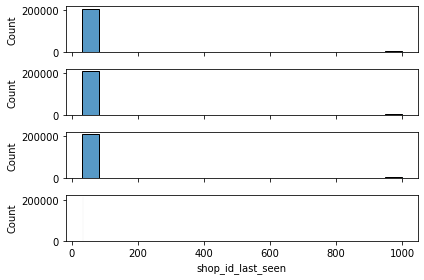

In [22]:
f, axes = plt.subplots(4, 1, sharex=True)
for i, month in enumerate([31, 32, 33, 34]):
    month_df = sales_train[sales_train['date_block_num'] < month]\
        .groupby('shop_id')['date_block_num'].max().reset_index()
    month_df.rename(columns={'date_block_num': 'shop_id_last_seen'}, inplace=True)
    samples = test_set[['item_id', 'shop_id']].copy()
    df = samples.merge(month_df, on='shop_id', how='left').fillna(999)
    sns.histplot(df['shop_id_last_seen'], ax=axes[i])
plt.tight_layout()

This is because the shops from the test set are chosen from the last month, so it doesn't make a lot of sense to test for the last time the shop was seen.

This can be happening with other features too, such as the item id version of it. A solution might be to try again to brute force the generating function of the test samples. Let's start by double checking if the pairs are just all possible combinations of the chosen shops and items.

In [47]:
test_shops = np.sort(test_set['shop_id'].unique())
test_items = np.sort(test_set['item_id'].unique())
test_shops.shape[0] * test_items.shape[0]

214200

In [48]:
test_set.shape[0]

214200

Ok, now we just have to find the generating function for the independent shop ids and item ids. We have a hint for the shop id, which shold be the shops seen on the last train month.

In [66]:
shops_month_33 = sales_train[sales_train['date_block_num'] == 33]['shop_id'].unique()
np.setdiff1d(shops_month_33, test_shops), np.setdiff1d(test_shops, shops_month_33)

(array([ 9, 20]), array([], dtype=int64))

Ok, shops 9 and 20 were not present, so it's possible that a shop disappears from one month to the other. To account for this, let's limit the train set shop ids to just the ones seen on the test set and, after filtering it, we will only keep a shop if it was seen on the previous month.

In [50]:
train_set_shops = pd.DataFrame(columns=['shop_id', 'date_block_num'])
shops_sales_train = sales_train[['shop_id', 'date_block_num']].drop_duplicates()

for month in trange(0, 35): # including test month for debugging
    candidates = pd.DataFrame({'shop_id': test_shops, 'date_block_num': month - 1})
    candidates.merge(shops_sales_train, on=['shop_id', 'date_block_num'])
    candidates['date_block_num'] = month
    train_set_shops = train_set_shops.append(candidates)
train_set_shops.describe()

,shop_id,date_block_num
count,1470,1470
unique,42,35
top,59,34
freq,35,42


Let's check if the generated shop ids for the test set month match the original.

In [77]:
np.tile([1, 2], 3), np.repeat([1, 2, 3], 2)

(array([1, 2, 1, 2, 1, 2]), array([1, 1, 2, 2, 3, 3]))

In [51]:
np.equal(train_set_shops[train_set_shops['date_block_num'] == 34]['shop_id'], test_shops).all()

True

Great. We can drop the test month and continue to investigate the item ids.

In [65]:
items_month_33 = np.sort(sales_train[sales_train['date_block_num'] == 33]['item_id'].unique())
np.setdiff1d(items_month_33, test_items).shape, np.setdiff1d(test_items, items_month_33).shape

((1422,), (1109,))

Ok. Items are not bound to have appeared on the last month. Let's see how many months we have to include to have all of them.

In [67]:
for window in range(1, 35):
    items_train = sales_train[sales_train['date_block_num'] > 33 - window]['item_id'].unique()
    if np.setdiff1d(test_items, items_train).shape[0] == 0:
        break
window, np.setdiff1d(test_items, items_train).shape[0]

(34, 363)

So there are new items on the test set, but there's also items that are discontinued on the test set.

In [71]:
items_month_33.shape[0], test_items.shape[0]

(5413, 5100)

Maybe the test items are actually from sales that happened during that month. Let's see if the numbers make sense in a time series.

<AxesSubplot:>

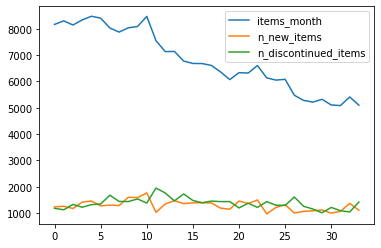

In [74]:
def items_in_month(month):
    return sales_train[sales_train['date_block_num'] == month]['item_id'].unique()

items_month = [items_in_month(month).shape[0] for month in range(1, 34)]
new_items_per_month = [np.setdiff1d(items_in_month(month), items_in_month(month - 1)).shape[0] for month in range(1, 34)]
discontinued_items_per_month = [np.setdiff1d(items_in_month(month - 1), items_in_month(month)).shape[0] for month in range(1, 34)]

items_month.append(test_items.shape[0])
new_items_per_month.append(np.setdiff1d(test_items, items_month_33).shape[0])
discontinued_items_per_month.append(np.setdiff1d(items_month_33, test_items).shape[0])

df = pd.DataFrame({'items_month': items_month,
                  'n_new_items': new_items_per_month,
                  'n_discontinued_items': discontinued_items_per_month})
df.plot()

It does make sense, so it might also make sense to just use the items that appear in a month for the train set.